## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Bonus Chapter 3 - Notebook 5: RNN curves

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

random_seed = 42

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    '''Add together multiple sine waves and return a list of values that is
    number_of_steps long. d_theta is the step (in radians) between samples.
    skip_steps determines the start of the sequence. The lists freqs, amps,
    and phases should all the same length (but we don't check!)'''
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
    return np.array(values)

In [5]:
def sum_of_upsloping_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    '''Like sum_of_sines(), but always sloping upwards'''
    np.random.seed(42)
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
        if step_num > 0:
            sum_change = sum - prev_sum
            if sum_change < 0:
                values[-1] *= -1
                if step_num == 1:
                    values[-2] *= -1
        prev_sum = sum
    return np.array(values)

In [6]:
def samples_and_targets_from_sequence(sequence, window_size):
    '''Return lists of samples and targets built from overlapping
    windows of the given size. Windows start at the beginning of 
    the input sequence and move right by 1 element.'''
    samples = []
    targets = []
    for i in range(sequence.shape[0]-window_size):
        sample = sequence[i:i+window_size]
        target = sequence[i+window_size]
        samples.append(sample)
        targets.append(target[0]) 
    return (np.array(samples), np.array(targets))

In [7]:
def make_data(data_sequence_number, training_length):
    training_sequence = test_sequence = []
    test_length = 200
    theta_step = .057
    if data_sequence_number == 0:
        freqs_list = [1, 2]
        amps_list = [1, 2]
        phases_list = [0, 0]
        data_maker = sum_of_sines
    elif data_sequence_number == 1:
        freqs_list = [1.1, 1.7, 3.1, 7]
        amps_list = [1,2,2,3]
        phases_list = [0,0,0,0]
        data_maker = sum_of_sines
    elif data_sequence_number == 2:
        freqs_list = [1.1, 1.7, 3.1, 7]
        amps_list = [1,2,2,3]
        phases_list = [0,0,0,0]
        data_maker = sum_of_upsloping_sines
    else:
        print("***** ERROR! Unknown data_sequence_number = ",data_sequence_number)
    training_sequence = data_maker(training_length, theta_step, 0, freqs_list, amps_list, phases_list)
    test_sequence = data_maker(test_length, theta_step, 2*training_length, freqs_list, amps_list, phases_list)
    return (training_sequence, test_sequence)

In [8]:
def show_data_sets(training_length):
    for i in range(0, 3):
        (training_sequence, test_sequence) = make_data(i, training_length)
        plt.figure(figsize=(8,3))
        
        plt.subplot(1, 2, 1)
        plt.plot(training_sequence)
        plt.title('training sequence, set '+str(i))
        plt.xlabel('index')
        plt.ylabel('value')
        
        plt.subplot(1, 2, 2)
        plt.plot(test_sequence)
        plt.title('test sequence, set '+str(i))
        plt.xlabel('index')
        plt.ylabel('value')
        
        plt.tight_layout()
        file_helper.save_figure('RNN-data-set-'+str(i))
        plt.show()

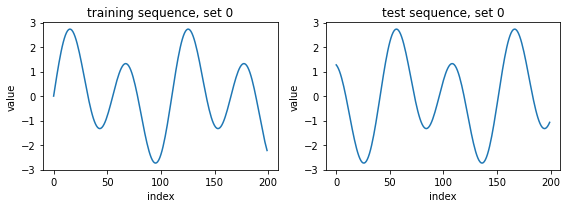

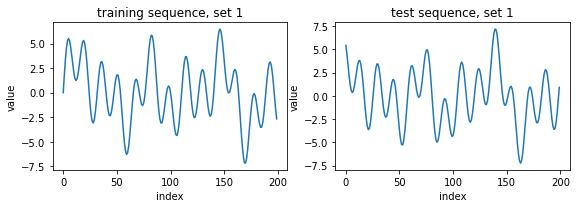

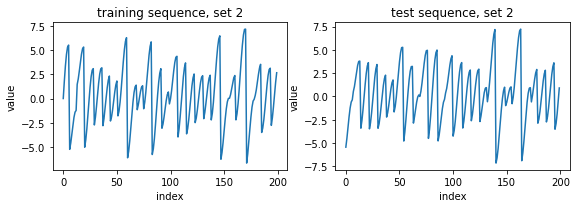

In [9]:
show_data_sets(training_length=200)

In [10]:
def scale_sequences(training_sequence, test_sequence):
    # reshape train and test sequences to form needed by MinMaxScaler
    training_sequence = np.reshape(training_sequence, (training_sequence.shape[0], 1))
    test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))
    Min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    Min_max_scaler.fit(training_sequence)
    scaled_training_sequence = Min_max_scaler.transform(training_sequence)
    scaled_test_sequence = Min_max_scaler.transform(test_sequence)
    return (Min_max_scaler, scaled_training_sequence, scaled_test_sequence)

In [11]:
# chop up train and test sequences into overlapping windows of the given size
def chop_up_sequences(training_sequence, test_sequence, window_size):
    (X_train, y_train) = samples_and_targets_from_sequence(training_sequence, window_size)
    (X_test, y_test) = samples_and_targets_from_sequence(test_sequence, window_size)
    return (X_train, y_train, X_test, y_test)

In [12]:
def make_data_set(data_sequence_number, window_size, training_length):
    (training_sequence, test_sequence) = make_data(data_sequence_number, training_length)
    (Min_max_scaler, scaled_training_sequence, scaled_test_sequence) = \
            scale_sequences(training_sequence, test_sequence)
    (X_train, y_train, X_test, y_test)= chop_up_sequences(scaled_training_sequence, scaled_test_sequence, window_size)
    return (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence)

In [13]:
# build and run the first model. 
def make_model(model_number, window_size):
    model = Sequential()
    if model_number == 0:
        model.add(LSTM(3, input_shape=[window_size, 1]))
        model.add(Dense(1, activation=None))
    elif model_number == 1:
        model.add(LSTM(3, return_sequences=True, input_shape=[window_size, 1]))
        model.add(LSTM(3))
        model.add(Dense(1, activation=None))
    elif model_number == 2:
        model.add(LSTM(9, return_sequences=True, input_shape=[window_size, 1]))
        model.add(LSTM(6, return_sequences=True))
        model.add(LSTM(3))
        model.add(Dense(1, activation=None))
    else:
        print("*** ERROR: make_model unknown model_number = ",model_number)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
def build_and_compare(model_number, data_set_number, window_size, training_length, epochs):
    np.random.seed(random_seed)
    model = make_model(model_number, window_size)
    (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence) = \
        make_data_set(data_set_number, window_size, training_length)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)
    
    # Predict 
    y_train_predict = np.ravel(model.predict(X_train))
    y_test_predict = np.ravel(model.predict(X_test))
    
    # invert transformation
    inverse_y_train_predict = Min_max_scaler.inverse_transform([y_train_predict])
    inverse_y_test_predict = Min_max_scaler.inverse_transform([y_test_predict])    
    
    plot_string = '-dataset-'+str(data_set_number)+'-window-'+str(window_size)+\
                    '-model_number-'+str(model_number)+'-length-'+str(training_length)+'-epochs-'+str(epochs)
        
    plt.plot(history.history['loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss for data set '+str(data_set_number)+', window '+str(window_size))
    file_helper.save_figure('RNN-loss'+plot_string)
    plt.show()
    
    # plot training and predictions

    plt.plot(training_sequence, label="train", color='black', linewidth=2, zorder=20)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_train_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="train predict", color='red', linewidth=2, zorder=10)
    plt.legend(loc='best')
    plt.xlabel('index')
    plt.ylabel('train and prediction')
    plt.title('training set '+str(data_set_number)+', window '+str(window_size))    
    file_helper.save_figure('RNN-train-predictions'+plot_string)
    plt.show()
    
    plt.plot(test_sequence, label="test", color='black', linewidth=2, zorder=20)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_test_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="test predict", color='red', linewidth=2, zorder=10)
    plt.legend(loc='best')
    plt.xlabel('index')
    plt.ylabel('test and prediction')
    plt.title('test set '+str(data_set_number)+', window '+str(window_size))
    plt.tight_layout()
    file_helper.save_figure('RNN-test-predictions'+plot_string)
    plt.show()

### Slow Alert!

If you're running without a GPU (and maybe even if you are), the last two
of these runs will take a while. It might be hours, or even days. Plan ahead!


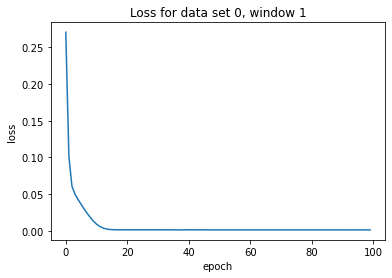

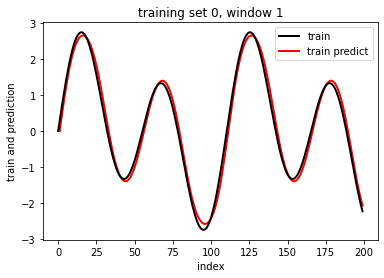

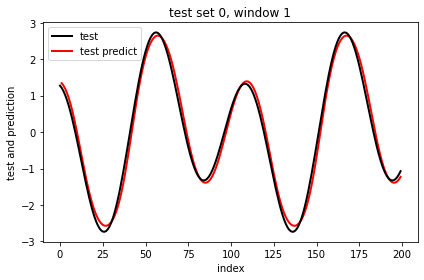

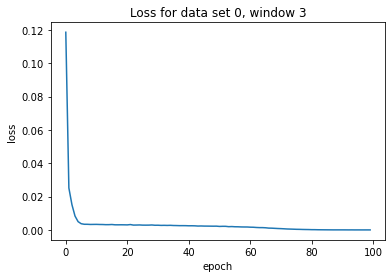

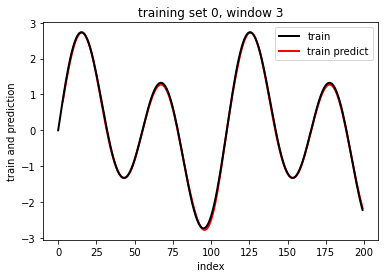

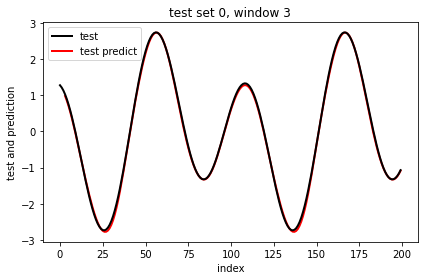

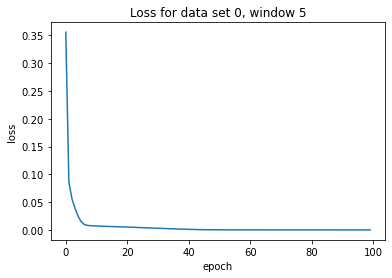

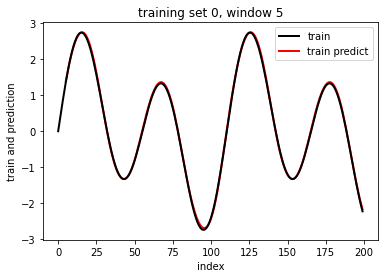

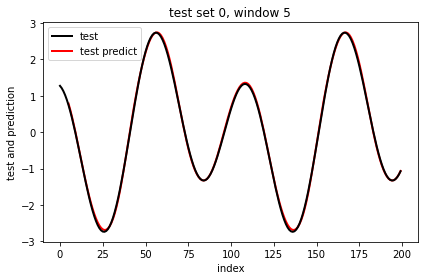

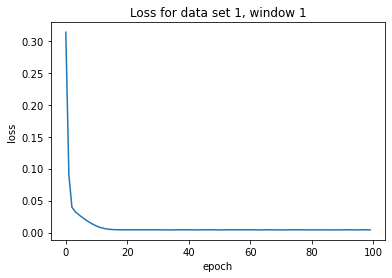

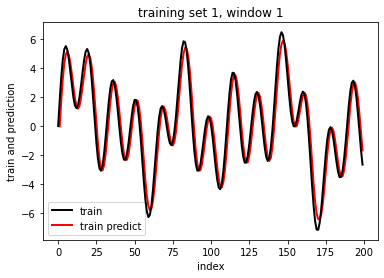

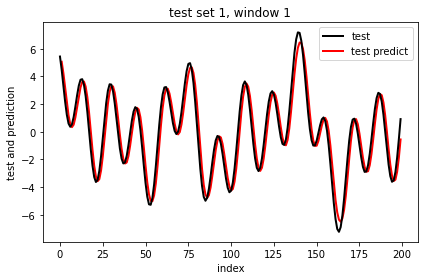

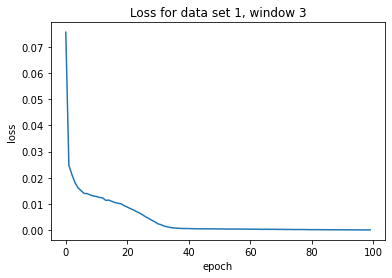

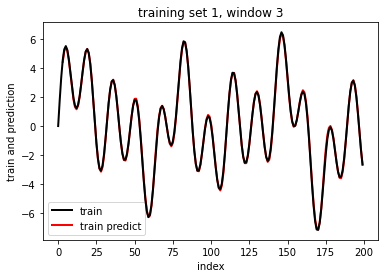

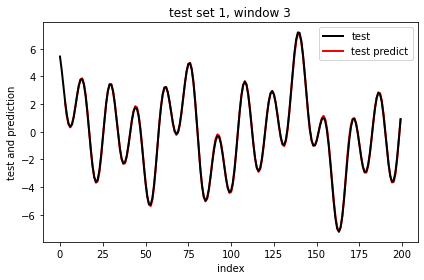

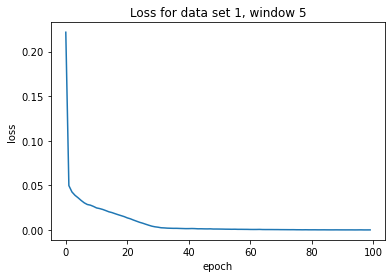

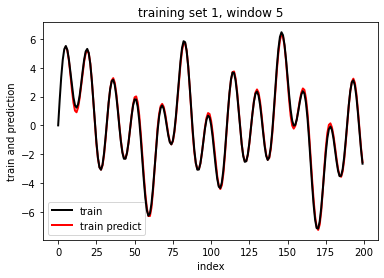

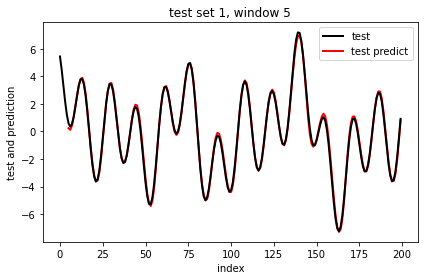

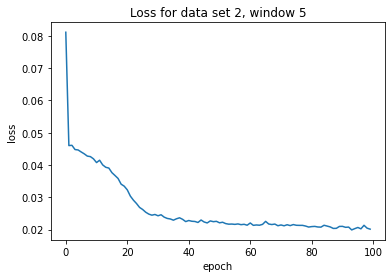

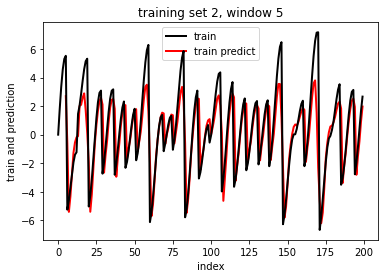

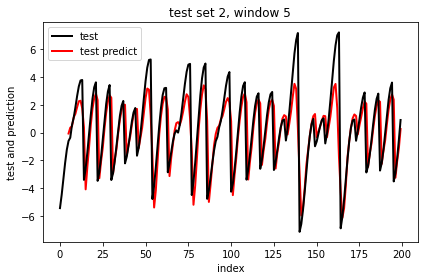

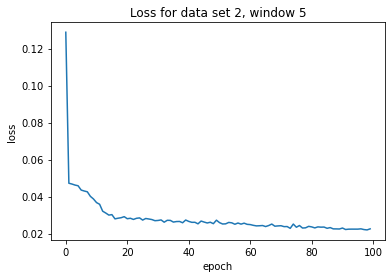

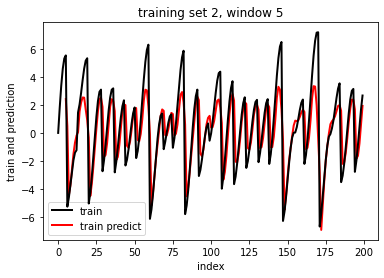

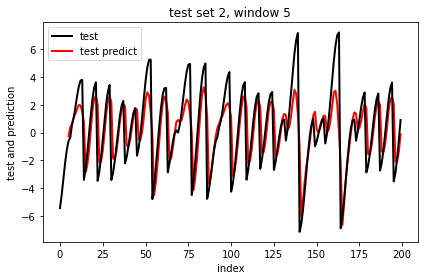

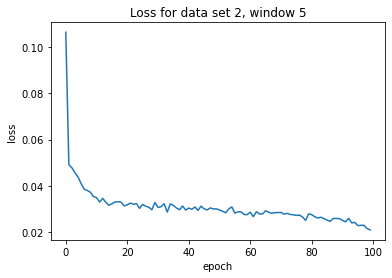

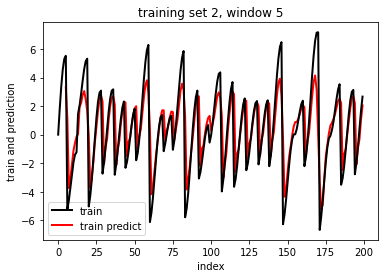

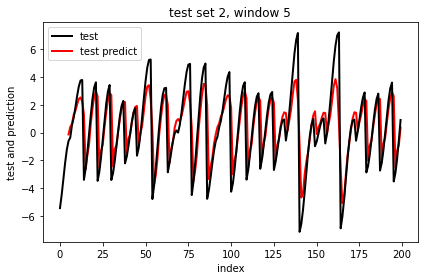

In [15]:
build_and_compare(model_number=0, data_set_number=0, window_size=1, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=0, window_size=3, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=0, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=0, data_set_number=1, window_size=1, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=1, window_size=3, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=1, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=0, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=1, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=2, data_set_number=2, window_size=5, training_length=200, epochs=100)
#build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=2000, epochs=100)
#build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=20000, epochs=100)